# Importar Librerias

In [ ]:
# Importar librerias de uso general
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importar Datos

In [ ]:
# Importar los datos en un dataframe
pd.set_option('display.max_columns', 500)
data = pd.read_csv('loan.csv',low_memory=False)
data.head(3)

In [ ]:
# Obtener las estadisticas descriptivas
data.describe()

# Filtrar Datos

In [ ]:
# Se eliminan las columnas con mas de 90% de sus valores perdidos (nulos)
print('Eliminando columnas con mas de 90% de valores perdidos...')
print(f'Cantidad de columnas originales: {data.shape[1]}')
cols_elim = [x for x in data.columns if data[x].isnull().sum()/data.count().max()>=0.10]
print(f'Cantidad de columnas a eliminar: {len(cols_elim)}')
data_clear = data.drop(columns=cols_elim,axis=1)
print(f'Cantidad de columnas finales: {data_clear.shape[1]}')
print('---------------')
# Eliminar columnas cuyos nombres contengan id_
id_lst=list(map(lambda x: 'id' in x,data_clear.columns))
id_column_name_lst = list(data_clear.columns[id_lst])
print('Eliminando columnas que contengan un id')
print(f'Numero de columnas original: {len(data_clear.columns.tolist())}')
data_clear.drop(columns=id_column_name_lst, axis=1,inplace=True)
print(f'Numero de columnas filtrado: {len(data_clear.columns.tolist())}')
print('---------------')
# Eliminar columnas cuyos nombres contengan _d (fechas)
id_lst=list(map(lambda x: '_d' in x,data_clear.columns))
id_column_name_lst = list(data_clear.columns[id_lst])
print('Eliminando columnas que contengan un dato que sea fecha (terminan en _d)')
print(f'Numero de columnas original: {len(data_clear.columns.tolist())}')
data_clear.drop(columns=id_column_name_lst, axis=1,inplace=True)
print(f'Numero de columnas filtrado: {len(data_clear.columns.tolist())}')

In [ ]:
# Buscar las columnas que tienen datos potencialmente categoricos y convertir sus valores de acuerdo al mismo
print('Convirtiendo las categorias nominales en numericas mediante codificacion')
cat_cols = data_clear.select_dtypes(include='object').columns.tolist()
cat_cols.remove('loan_status')
print(f'Se encontraron {len(cat_cols)} columnas por convertir.')
cat_dict = dict()
for col in cat_cols:
    data_clear[col] = data_clear[col].astype('category')
    cat_dict[col] = {i+1:c for i,c in enumerate(data_clear[col].cat.categories)}
    data_clear[col] = data_clear[col].cat.codes+1
print('Columnas convertidas con exito.')
print('---------------')

# Se mira la cantidad de categorias que tiene cada columna. Asimismo, se identifican aquellas que tienen una cantidad
# muy alta de categorias distintas (>10% de la cantidad de registros de la columna)
print(f'Eliminando columnas nominales que tienen demasiados valores distintos (limite: 10% del total de la columna)')
debug = False
cols_elim = []
for keys,values in cat_dict.items():
    if debug:
        print(f'{keys} => {len(values)} de {data_clear.count().max()} ({round(100*len(values)/data_clear.count().max(),2)}%)')
    if len(values)/data_clear.count().max() >= 0.1:
        cols_elim.append(keys)
print(f'Cantidad actual de columnas: {len(data_clear.columns.tolist())}')
data_clear.drop(columns=cols_elim, axis=1, inplace=True)
print(f'Cantidad nueva de columnas: {len(data_clear.columns.tolist())}')
print('---------------')

# Se rellenan los vacios con la mediana
print('Rellenando los vacios con la mediana...')
data_clear = data_clear.fillna(value=data_clear.median())
data_clear = data_clear.reset_index(drop=True)
print('Se rellenaron los vacios.')

In [ ]:
# Se explora la variable target (loan_status)
import warnings
def analisis_agregacion(dataframe,groupby_col,idx_opt):
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore',category=FutureWarning)
        #aggregation_function = {'id':{'cuenta':'count'},'loan_amnt':{'suma':'sum','contador':lambda x: int(sum(x)/data2.loc[x.index].loan_amnt.sum())}}
        aggregation_function = {'loan_amnt':['count','sum']}
        data_res=dataframe.groupby(groupby_col,as_index=idx_opt).agg(aggregation_function)
    data_res['loan_amnt','porcentaje_cuenta'] = round(data_res['loan_amnt','count']/data_res['loan_amnt'].sum()[0]*100,2)
    data_res['loan_amnt','tporcentaje_monto'] = round(data_res['loan_amnt','sum']/data_res['loan_amnt'].sum()[1]*100,2)
    return data_res.sort_index(axis=1)

print('Distribucion de la variable loan_status')
print(analisis_agregacion(data_clear,'loan_status',True))

In [ ]:
# Se observa que no todos los valores son validos o aplicables al caso.
# Por ello, se filtran los registros inconsistentes o no aplicables para analisis:
#    Current -> No aplicable porque son préstamos dentro de su periodo de pago.
#    Does not meet the credit policy (...) -> Inconsistente. No se sabe si es un error o un valor correcto.
#    Issued -> No aplicable porque son créditos recién emitidos.
#    In grace period -> No aplicable porque son créditos en periodo de gracia.
print('Eliminando registros inconsistentes o no aplicables para analisis.')
estados_eliminar = {'In Grace Period','Current','Does not meet the credit policy. Status:Fully Paid', 'Does not meet the credit policy. Status:Charged Off', 'Issued'}
data_clear_final = data_clear
for estado in estados_eliminar:
    data_clear_final.drop(data_clear_final[data_clear_final.loan_status==estado].index,inplace=True)
    print(f'Eliminado {estado}. Quedan: {data_clear_final.count()[0]}')
print('Se eliminaron registros no aplicables')
print('Nueva distribucion:')
print('==============================================================================================')
print(analisis_agregacion(data_clear_final,'loan_status',True))
print('==============================================================================================')

In [ ]:
# Se genera la variable de destino (target) con la siguiente codificacion: 
# -1 -> Prestamo no pagado.
#   Registros cuyo estado es diferente a 'Fully Paid', seran agrupados en la clase 'no pagado' = -1
# +1 -> Prestamo pagado
#   Registros cuyo estado es igual a 'Fully Paid'    , seran agrupados en la clase 'pagado'    = +1
print('Creando columna de clase...')
data_clear_final['class'] = 2*(data_clear_final['loan_status'] == 'Fully Paid')-1
print('==============================================================================================')
print('Distribucion de la nueva columna:')
print('')
print(analisis_agregacion(data_clear_final,['class','loan_status'],True))

print('==============================================================================================')
print('Se separa el set X del Y')
X = data_clear_final[data_clear_final.drop(columns=['loan_status','class'],axis=1).columns.tolist()]
y = data_clear_final['class']
print(f'Las dimensiones de X son: {X.shape}')
print(f'Las dimensiones de y son: {y.shape}')


In [ ]:
# Sugerencia: borrar columnas con poca varianza

# Preparar Datos

In [ ]:
# Preparacion experimental
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separar el conjunto de entrenamiento/validacion del conjunto de prueba
print('Separando el conjunto de entrenamiento del de pruebas')
print(f'El tamaño original de X es {len(X)}')
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.90, random_state=40)
print(f'El tamaño del set de entrenamiento es: {len(X_trainval)}')
print(f'El tamaño del set de pruebas es: {len(X_test)}')
#print(f'El tamaño del set entrenamiento + pruebas es {len(X_trainval+X_test)}')

# Normalizar el conjunto de entrenamiento/valdiacion
print('')
print('Ejecutando normalizacion...')
scaler = StandardScaler().fit(X_trainval)
X_trainval_scaled = scaler.transform(X_trainval)
print('Set de pruebas normalizado')

# Seleccion de Caracteristicas (feature selection)

In [ ]:
# importar librerias para la seleccion de caracteristicas
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [ ]:
# Sea conjunto_n_caracteristicas = {10,20,30} el conjunto de dimensiones
# Sea conjunto_algoritmos = {Logistic_Regresion, RandomForest, SVM}
# Para cada n_caracteristicas en conjunto_n_caracteristicas:
#   Para cada algoritmo en conjunto_algoritmo:
#      conjunto_caracteristas[algoritmo] = reducirCaracteristicas(n_dim,algoritmo)
#   caracteristicas_comunes[n_caracteristicas] = unirCaracteristicas(conjunto_caracteristicas)
#   scores[n_caracteristicas] = entrenarClasificador(caracteristicas_comunes)
# mejor_conjunto_caracteristicas = encontrarMejorConjunto(caracteristicas_comunes, scores)

In [ ]:
# Clasificador SVM de kernel lineal
svc = SVC(kernel='linear', C=1)
# Se calcula las 30 caracteristicas mas importantes para este modelo
rfe_svc = RFE(estimator=svc, n_features_to_select=30, step=5, verbose=2)
rfe_svc.fit(X_trainval, y_trainval)
svc_selected_columns = [X_trainval.columns.values[i] for i in range(len(X_trainval.columns.values)) if  rfe_svc.support_[i]]

In [ ]:
# Clasificador de Regresion Logistica
lr = LogisticRegression()
# Se calcula las 30 caracteristicas mas importantes para este modelo
rfe_lr = RFE(estimator=lr, n_features_to_select=30, step=5, verbose=2)
rfe_lr.fit(X_trainval, y_trainval)
lr_selected_columns = [X_trainval.columns.values[i] for i in range(len(X_trainval.columns.values)) if  rfe_lr.support_[i]]

In [130]:
# Cada clasificador utilizado ha generado un set de caracteristicas mas relevantes segun cada modelo
# Ahora, se genera una mascara para indicar si una caracteristica ha estado presentes en cada modelo analizado
common_features_mask = np.logical_and(rfe_svc.support_,rfe_lr.support_)
print(f'Numero de caracteristicas comunes: {np.sum(common_features_mask)}')

Numero de caracteristicas comunes: 27


In [143]:
# Columnas a eliminar segun la mascara generada
columns_to_be_dropped = [X_trainval.columns.values[i] for i in range(len(X_trainval.columns.values)) if  not(common_features_mask[i])]

In [145]:
# Se remueve los datos referentes a las caracteristicas a eliminar
X_trainval_reduced = X_trainval.drop(columns_to_be_dropped,axis=1)
X_test_reduced = X_test.drop(columns_to_be_dropped, axis=1)

# Construir Clasificador

In [147]:
# Se importa la libreria para el clasificador  de Random Forest
from sklearn.ensemble import RandomForestClassifier

In [159]:
# Se genera una instancia del clasificador
clf = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)

In [160]:
# Se entrena el clasificador con los datos filtrados por la reduccion de caracteristicas
clf.fit(X_trainval_reduced, y_trainval)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

# Evaluar Modelo

In [206]:
# Se importan librerias relacionadas a la evaluacion de modelos
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools

In [163]:
# Se predice la clase para los datos de prueba
y_pred = clf.predict(X_test_reduced)

In [178]:
# funcion para general el grafico de matriz de confusion
# adaptado de: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [169]:
# matriz de confusion
cnf_matrix = confusion_matrix(y_test, y_pred)

In [202]:
# Etiqueta de las clases
class_names = ['No Pagado','Pagado']

Confusion matrix, without normalization
[[ 53764    617]
 [    67 186877]]


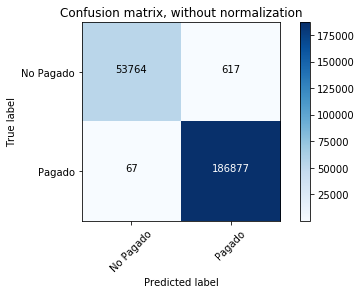

In [203]:
# Se genera la grafica de la matriz de confusion
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

In [212]:
# Metricas parfa la evaluacion de resultados
# tn = veraderos negativos
# fp = falsos positivos
# fn = falsos negativos
# tp = verdaderos positivos
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [223]:
# Se imprimen las metricas para evaluar los resultados
print(f'score del modelo : {clf.score(X_test_reduced, y_test)}')
print(f'precison         : {(tp)/(tp+fp)}')
print(f'recall           : {tp/(tp+fn)}')

score del modelo : 0.9971656479850823
precison         : 0.9967092280286303
recall           : 0.999641603902773
